# EfficientNet-B0: 5-Fold Cross-Validation with Confusion Matrix per Fold

This notebook implements a clean 80-20 train-test split followed by 5-fold cross-validation with **no data reuse**.
Each fold contains a completely separate subset of the training data.
A confusion matrix is generated after each fold, and final average train and test accuracies are reported.

**Model: EfficientNet-B0**

In [1]:
# Import necessary libraries
import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import PyTorch components
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models

# Import scikit-learn for splitting and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.benchmark = True  # Speed up training

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define Dataset Path
DATASET_PATH = "C:/Users/vishv/OneDrive/Desktop/Data Science/New Example/CT Scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Resized"

# Get class labels (folder names)
class_labels = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])

# Print basic info
print(f"Found {len(class_labels)} classes: {class_labels}")

# Dictionary to store image file paths
image_files = {label: [] for label in class_labels}

# Read images from each class
for label in class_labels:
    class_dir = os.path.join(DATASET_PATH, label)
    image_files[label] = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Print number of images per class
total_images = 0
for label, files in image_files.items():
    print(f"Class '{label}': {len(files)} images")
    total_images += len(files)
    
print(f"\nTotal images in dataset: {total_images}")

Found 4 classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Class 'Cyst': 3284 images
Class 'Normal': 5002 images
Class 'Stone': 1360 images
Class 'Tumor': 2283 images

Total images in dataset: 11929


In [4]:
# Function to extract patient ID from filename
def get_patient_id(filename):
    # Extract patient ID from filename using regex
    match = re.search(r'(\d+)', os.path.basename(filename))
    return match.group(1) if match else os.path.basename(filename)

# Custom dataset class with patient ID tracking
class KidneyCTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        self.samples = []
        self.patient_to_samples = {}
        
        # Load all image paths and organize by patient ID
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_name)
                    patient_id = get_patient_id(img_path)
                    
                    # Add to samples list
                    idx = len(self.samples)
                    self.samples.append((img_path, self.class_to_idx[class_name]))
                    
                    # Add to patient mapping
                    if patient_id not in self.patient_to_samples:
                        self.patient_to_samples[patient_id] = []
                    self.patient_to_samples[patient_id].append(idx)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # EfficientNet-B0 works well with 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = KidneyCTDataset(root_dir=DATASET_PATH, transform=transform)

# Get all patient IDs
patient_ids = list(dataset.patient_to_samples.keys())
print(f"Total patients: {len(patient_ids)}")
print(f"Total images: {len(dataset)}")

Total patients: 5077
Total images: 11929


In [6]:
# Step 1: Perform a clean 80-20 split by patient ID
train_patients, test_patients = train_test_split(
    patient_ids, 
    test_size=0.2, 
    random_state=42
)

print(f"Train-Test Split (by patient):")
print(f"  Train: {len(train_patients)} patients ({len(train_patients)/len(patient_ids):.1%} of all patients)")
print(f"  Test: {len(test_patients)} patients ({len(test_patients)/len(patient_ids):.1%} of all patients)")

# Get sample indices for each split
train_indices = [idx for patient in train_patients for idx in dataset.patient_to_samples[patient]]
test_indices = [idx for patient in test_patients for idx in dataset.patient_to_samples[patient]]

print(f"\nTrain-Test Split (by image):")
print(f"  Train: {len(train_indices)} images ({len(train_indices)/len(dataset):.1%} of all images)")
print(f"  Test: {len(test_indices)} images ({len(test_indices)/len(dataset):.1%} of all images)")

Train-Test Split (by patient):
  Train: 4061 patients (80.0% of all patients)
  Test: 1016 patients (20.0% of all patients)

Train-Test Split (by image):
  Train: 9529 images (79.9% of all images)
  Test: 2400 images (20.1% of all images)


In [7]:
# Step 2: Divide the training patients into 5 completely separate folds
# Shuffle the training patients
random.shuffle(train_patients)

# Split into 5 equal groups
num_folds = 5
fold_size = len(train_patients) // num_folds
fold_patients = [train_patients[i*fold_size:(i+1)*fold_size] for i in range(num_folds)]

# Handle any remaining patients
for i in range(len(train_patients) % num_folds):
    fold_patients[i].append(train_patients[num_folds*fold_size + i])

# Create a list to store fold information
folds = []

print("\n5-Fold Split (No Data Reuse):")
for fold_idx in range(num_folds):
    # Get sample indices for this fold
    fold_indices = [idx for patient in fold_patients[fold_idx] for idx in dataset.patient_to_samples[patient]]
    
    # Store fold information
    folds.append({
        'patients': fold_patients[fold_idx],
        'indices': fold_indices
    })
    
    print(f"Fold {fold_idx+1}: {len(fold_patients[fold_idx])} patients, {len(fold_indices)} images")

# Verify no overlap between folds
for i in range(num_folds):
    for j in range(i+1, num_folds):
        overlap = set(folds[i]['indices']).intersection(set(folds[j]['indices']))
        if len(overlap) > 0:
            print(f"❌ Overlap between fold {i+1} and fold {j+1}: {len(overlap)} images")
        else:
            print(f"✓ No overlap between fold {i+1} and fold {j+1}")


5-Fold Split (No Data Reuse):
Fold 1: 813 patients, 1931 images
Fold 2: 812 patients, 1884 images
Fold 3: 812 patients, 1937 images
Fold 4: 812 patients, 1879 images
Fold 5: 812 patients, 1898 images
✓ No overlap between fold 1 and fold 2
✓ No overlap between fold 1 and fold 3
✓ No overlap between fold 1 and fold 4
✓ No overlap between fold 1 and fold 5
✓ No overlap between fold 2 and fold 3
✓ No overlap between fold 2 and fold 4
✓ No overlap between fold 2 and fold 5
✓ No overlap between fold 3 and fold 4
✓ No overlap between fold 3 and fold 5
✓ No overlap between fold 4 and fold 5


In [8]:
# Create test dataset
test_dataset = Subset(dataset, test_indices)

# Create test data loader (same for all folds)
test_loader = DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True
)

# Create fold datasets
fold_datasets = [Subset(dataset, fold['indices']) for fold in folds]

# Print fold sizes
print("Fold dataset sizes:")
for i, fold_dataset in enumerate(fold_datasets):
    print(f"  Fold {i+1}: {len(fold_dataset)} images")
print(f"  Test: {len(test_dataset)} images")

Fold dataset sizes:
  Fold 1: 1931 images
  Fold 2: 1884 images
  Fold 3: 1937 images
  Fold 4: 1879 images
  Fold 5: 1898 images
  Test: 2400 images


In [9]:
# Function to train a model for one epoch
def train_epoch(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Use tqdm for progress bar
    with tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=False) as t:
        for inputs, labels in t:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            t.set_postfix(loss=loss.item(), acc=100.*correct/total)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

# Function to evaluate the model
def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

In [10]:
# Function to generate predictions and true labels
def get_predictions(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Collect predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized ' + title
    else:
        fmt = 'd'
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, 
                xticklabels=classes, yticklabels=classes, 
                square=True, cbar=True)
    
    plt.title(title, fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

In [11]:
# Function to initialize EfficientNet-B0 model
def initialize_efficientnet_b0():
    # Load pre-trained EfficientNet-B0 model
    model = models.efficientnet_b0(weights='DEFAULT')
    
    # Modify the classifier for our number of classes
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=num_ftrs, out_features=len(class_labels))
    )
    
    return model.to(device)

In [12]:
# Function to train EfficientNet-B0 models on each fold
def train_efficientnet_b0_on_folds(num_epochs=10, batch_size=8):
    # Results storage
    fold_results = []
    all_train_accs = []
    all_test_accs = []
    
    # Loop through each fold
    for fold_idx in range(num_folds):
        print(f"\n=== Training EfficientNet-B0 on Fold {fold_idx+1}/{num_folds} ===\n")
        
        # Create data loader for this fold
        train_loader = DataLoader(
            fold_datasets[fold_idx],
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True
        )
        
        print(f"Training on {len(fold_datasets[fold_idx])} images")
        
        # Initialize EfficientNet-B0 model
        model = initialize_efficientnet_b0()
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Training loop
        results = {
            'train_loss': [], 'train_acc': [],
            'test_loss': 0, 'test_acc': 0,
            'final_train_acc': 0
        }
        
        for epoch in range(num_epochs):
            # Train for one epoch
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch)
            
            # Print statistics
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            
            # Save statistics
            results['train_loss'].append(train_loss)
            results['train_acc'].append(train_acc)
            
            # Save the final train accuracy for the last epoch
            if epoch == num_epochs - 1:
                results['final_train_acc'] = train_acc
                all_train_accs.append(train_acc)
        
        # Save the final model
        model_path = f'efficientnet_b0_fold{fold_idx+1}.pth'
        torch.save(model.state_dict(), model_path)
        print(f'Saved final model to {model_path}')
        
        # Evaluate on test set after training is complete
        test_loss, test_acc = evaluate(model, test_loader, criterion)
        results['test_loss'] = test_loss
        results['test_acc'] = test_acc
        all_test_accs.append(test_acc)
        
        print(f'\nFold {fold_idx+1} Results:')
        print(f'  Final Train Acc: {results["final_train_acc"]:.2f}%')
        print(f'  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
        # Generate confusion matrix for this fold
        print(f"\nGenerating confusion matrix for Fold {fold_idx+1}...")
        y_pred, y_true = get_predictions(model, test_loader, device)
        cm = confusion_matrix(y_true, y_pred)
        
        print(f"Confusion Matrix for Fold {fold_idx+1}:")
        print(cm)
        
        # Generate classification report
        report = classification_report(y_true, y_pred, target_names=class_labels)
        print(f"\nClassification Report for Fold {fold_idx+1}:")
        print(report)
        
        # Plot confusion matrices
        plot_confusion_matrix(cm, class_labels, normalize=False, 
                             title=f'EfficientNet-B0 Fold {fold_idx+1} Confusion Matrix')
        plot_confusion_matrix(cm, class_labels, normalize=True, 
                             title=f'EfficientNet-B0 Fold {fold_idx+1} Normalized Confusion Matrix')
        
        # Add to fold results
        fold_results.append(results)
    
    # Calculate average results across all folds
    avg_train_acc = np.mean(all_train_accs)
    avg_test_acc = np.mean(all_test_accs)
    
    print('\n=== Overall EfficientNet-B0 Results ===')
    print(f'Average Train Accuracy: {avg_train_acc:.2f}%')
    print(f'Average Test Accuracy: {avg_test_acc:.2f}%')
    
    # Plot training accuracy
    plt.figure(figsize=(15, 5))
    for i, fold_result in enumerate(fold_results):
        plt.plot(fold_result['train_acc'], '-', label=f'Fold {i+1} Train')
    plt.title(f'EfficientNet-B0 - Training Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Display final test accuracies
    plt.figure(figsize=(10, 6))
    test_accs = [fold['test_acc'] for fold in fold_results]
    plt.bar(range(1, num_folds+1), test_accs, color='#3498db')
    plt.axhline(y=avg_test_acc, color='r', linestyle='-', label=f'Average: {avg_test_acc:.2f}%')
    plt.title(f'EfficientNet-B0 - Test Accuracy by Fold', fontsize=14)
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.xticks(range(1, num_folds+1))
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels
    for i, v in enumerate(test_accs):
        plt.text(i+1, v+1, f"{v:.2f}%", ha='center', fontsize=10)
        
    plt.tight_layout()
    plt.show()
    
    # Display final train accuracies
    plt.figure(figsize=(10, 6))
    train_accs = [fold['final_train_acc'] for fold in fold_results]
    plt.bar(range(1, num_folds+1), train_accs, color='#2ecc71')
    plt.axhline(y=avg_train_acc, color='r', linestyle='-', label=f'Average: {avg_train_acc:.2f}%')
    plt.title(f'EfficientNet-B0 - Final Train Accuracy by Fold', fontsize=14)
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Train Accuracy (%)', fontsize=12)
    plt.xticks(range(1, num_folds+1))
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels
    for i, v in enumerate(train_accs):
        plt.text(i+1, v+1, f"{v:.2f}%", ha='center', fontsize=10)
        
    plt.tight_layout()
    plt.show()
    
    return fold_results


=== Training EfficientNet-B0 on Fold 1/5 ===

Training on 1931 images


Epoch 1:   0%|          | 0/242 [00:00<?, ?it/s]

Epoch 1/10:
  Train Loss: 0.7321, Train Acc: 72.29%


Epoch 2:   0%|          | 0/242 [00:00<?, ?it/s]

Epoch 2/10:
  Train Loss: 0.3536, Train Acc: 87.78%


Epoch 3:   0%|          | 0/242 [00:00<?, ?it/s]

Epoch 3/10:
  Train Loss: 0.2651, Train Acc: 90.89%


Epoch 4:   0%|          | 0/242 [00:00<?, ?it/s]

Epoch 4/10:
  Train Loss: 0.1354, Train Acc: 96.37%


Epoch 5:   0%|          | 0/242 [00:00<?, ?it/s]

Epoch 5/10:
  Train Loss: 0.1041, Train Acc: 96.63%


Epoch 6:   0%|          | 0/242 [00:00<?, ?it/s]

Epoch 6/10:
  Train Loss: 0.1169, Train Acc: 95.86%


Epoch 7:   0%|          | 0/242 [00:00<?, ?it/s]

Epoch 7/10:
  Train Loss: 0.0981, Train Acc: 97.05%


Epoch 8:   0%|          | 0/242 [00:00<?, ?it/s]

Epoch 8/10:
  Train Loss: 0.0475, Train Acc: 98.65%


Epoch 9:   0%|          | 0/242 [00:00<?, ?it/s]

Epoch 9/10:
  Train Loss: 0.0844, Train Acc: 97.57%


Epoch 10:   0%|          | 0/242 [00:00<?, ?it/s]

Epoch 10/10:
  Train Loss: 0.0538, Train Acc: 98.29%
Saved final model to efficientnet_b0_fold1.pth

Fold 1 Results:
  Final Train Acc: 98.29%
  Test Loss: 0.0751, Test Acc: 98.29%

Generating confusion matrix for Fold 1...
Confusion Matrix for Fold 1:
[[657   1   1   2]
 [  0 998   0   0]
 [ 10   4 261   0]
 [  4  19   0 443]]

Classification Report for Fold 1:
              precision    recall  f1-score   support

        Cyst       0.98      0.99      0.99       661
      Normal       0.98      1.00      0.99       998
       Stone       1.00      0.95      0.97       275
       Tumor       1.00      0.95      0.97       466

    accuracy                           0.98      2400
   macro avg       0.99      0.97      0.98      2400
weighted avg       0.98      0.98      0.98      2400



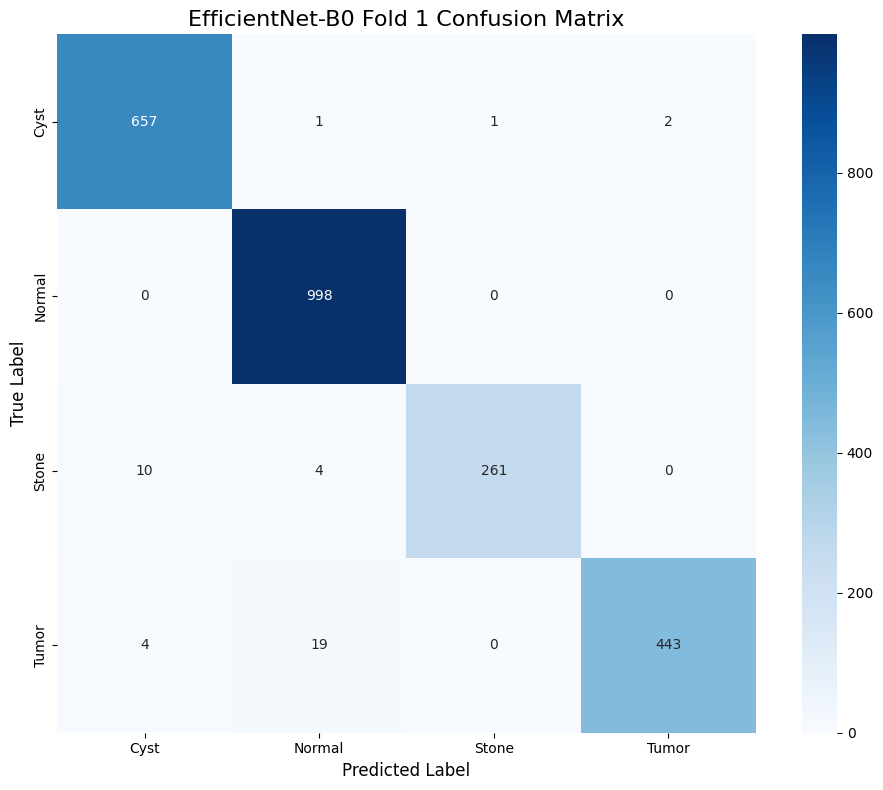

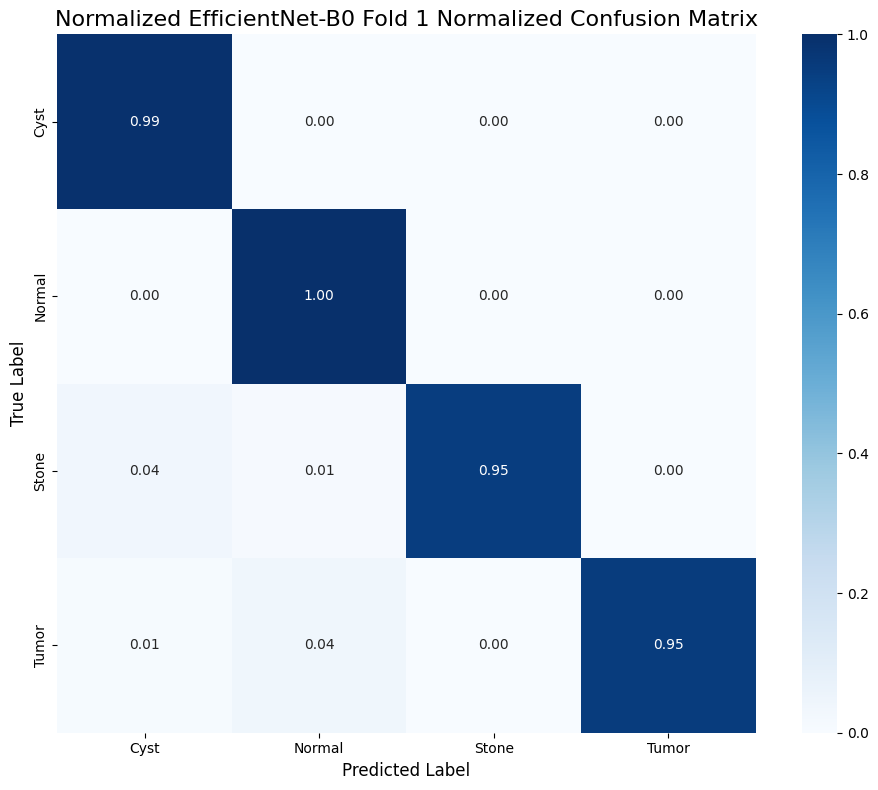


=== Training EfficientNet-B0 on Fold 2/5 ===

Training on 1884 images


Epoch 1:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch 1/10:
  Train Loss: 0.7195, Train Acc: 72.56%


Epoch 2:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch 2/10:
  Train Loss: 0.3543, Train Acc: 87.10%


Epoch 3:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch 3/10:
  Train Loss: 0.2492, Train Acc: 91.77%


Epoch 4:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch 4/10:
  Train Loss: 0.1363, Train Acc: 95.86%


Epoch 5:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch 5/10:
  Train Loss: 0.1545, Train Acc: 94.85%


Epoch 6:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch 6/10:
  Train Loss: 0.0882, Train Acc: 97.19%


Epoch 7:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch 7/10:
  Train Loss: 0.0590, Train Acc: 98.41%


Epoch 8:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch 8/10:
  Train Loss: 0.0927, Train Acc: 97.03%


Epoch 9:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch 9/10:
  Train Loss: 0.0510, Train Acc: 98.25%


Epoch 10:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch 10/10:
  Train Loss: 0.0793, Train Acc: 97.82%
Saved final model to efficientnet_b0_fold2.pth

Fold 2 Results:
  Final Train Acc: 97.82%
  Test Loss: 0.1337, Test Acc: 96.29%

Generating confusion matrix for Fold 2...
Confusion Matrix for Fold 2:
[[649   0  12   0]
 [  4 944  12  38]
 [ 19   0 255   1]
 [  3   0   0 463]]

Classification Report for Fold 2:
              precision    recall  f1-score   support

        Cyst       0.96      0.98      0.97       661
      Normal       1.00      0.95      0.97       998
       Stone       0.91      0.93      0.92       275
       Tumor       0.92      0.99      0.96       466

    accuracy                           0.96      2400
   macro avg       0.95      0.96      0.96      2400
weighted avg       0.96      0.96      0.96      2400



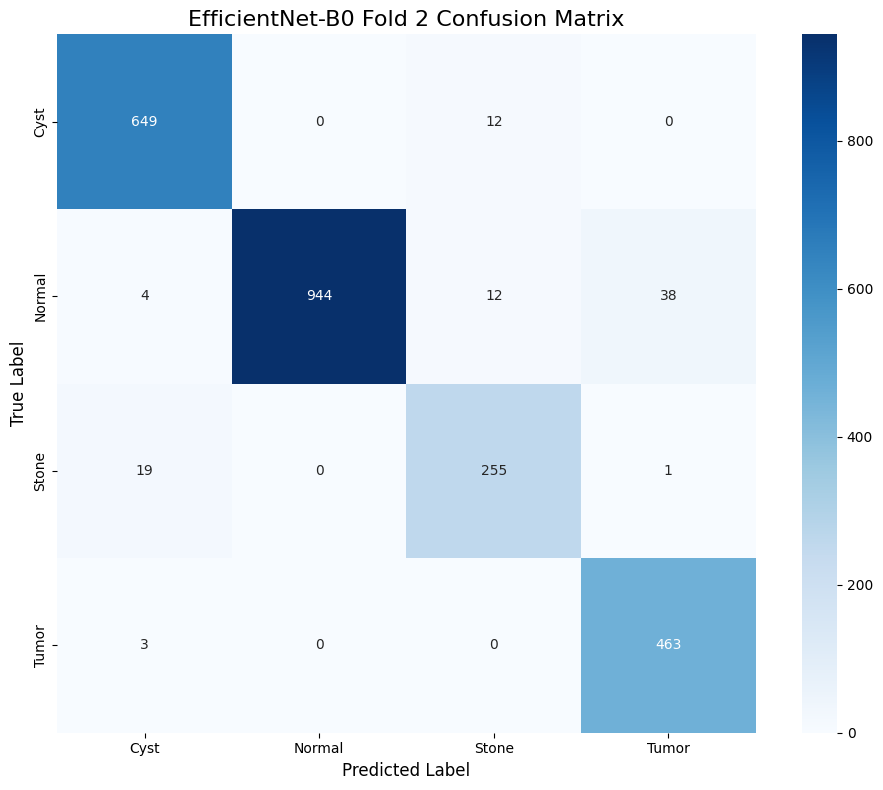

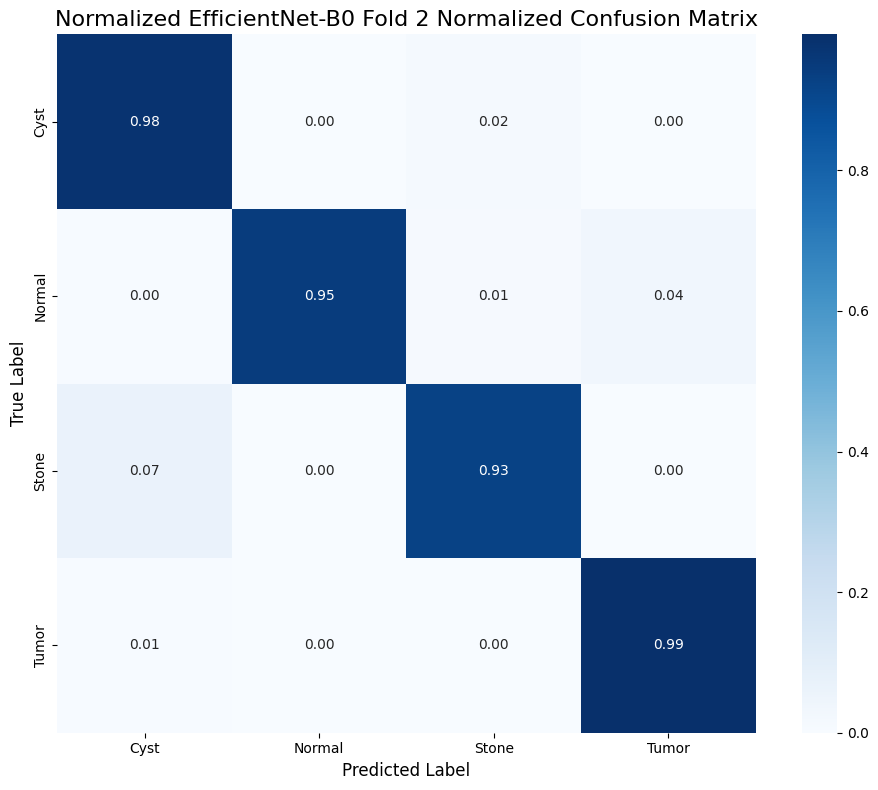


=== Training EfficientNet-B0 on Fold 3/5 ===

Training on 1937 images


Epoch 1:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 1/10:
  Train Loss: 0.7202, Train Acc: 73.36%


Epoch 2:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 2/10:
  Train Loss: 0.3663, Train Acc: 87.35%


Epoch 3:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 3/10:
  Train Loss: 0.1976, Train Acc: 92.77%


Epoch 4:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 4/10:
  Train Loss: 0.1665, Train Acc: 94.84%


Epoch 5:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 5/10:
  Train Loss: 0.1058, Train Acc: 96.49%


Epoch 6:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 6/10:
  Train Loss: 0.1207, Train Acc: 95.87%


Epoch 7:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 7/10:
  Train Loss: 0.0558, Train Acc: 98.45%


Epoch 8:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 8/10:
  Train Loss: 0.0527, Train Acc: 98.30%


Epoch 9:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 9/10:
  Train Loss: 0.0239, Train Acc: 99.23%


Epoch 10:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 10/10:
  Train Loss: 0.0638, Train Acc: 97.83%
Saved final model to efficientnet_b0_fold3.pth

Fold 3 Results:
  Final Train Acc: 97.83%
  Test Loss: 0.0317, Test Acc: 98.92%

Generating confusion matrix for Fold 3...
Confusion Matrix for Fold 3:
[[648   0   4   9]
 [  0 997   1   0]
 [  1   0 274   0]
 [  3   8   0 455]]

Classification Report for Fold 3:
              precision    recall  f1-score   support

        Cyst       0.99      0.98      0.99       661
      Normal       0.99      1.00      1.00       998
       Stone       0.98      1.00      0.99       275
       Tumor       0.98      0.98      0.98       466

    accuracy                           0.99      2400
   macro avg       0.99      0.99      0.99      2400
weighted avg       0.99      0.99      0.99      2400



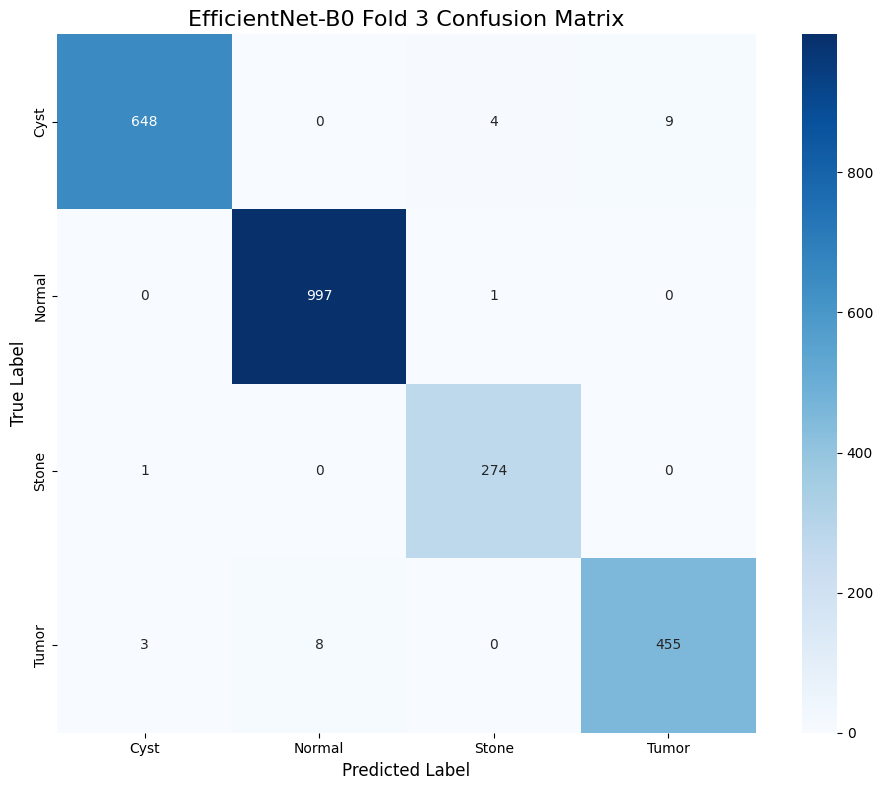

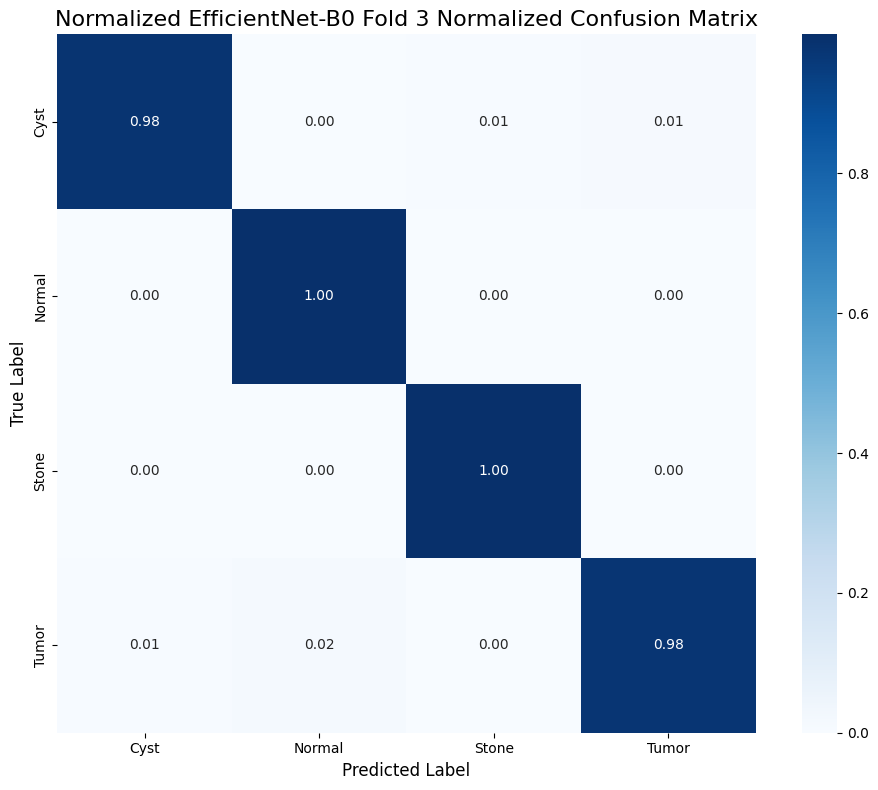


=== Training EfficientNet-B0 on Fold 4/5 ===

Training on 1879 images


Epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/10:
  Train Loss: 0.7410, Train Acc: 72.54%


Epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/10:
  Train Loss: 0.3769, Train Acc: 87.07%


Epoch 3:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/10:
  Train Loss: 0.2135, Train Acc: 93.29%


Epoch 4:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/10:
  Train Loss: 0.1746, Train Acc: 94.09%


Epoch 5:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/10:
  Train Loss: 0.1530, Train Acc: 94.73%


Epoch 6:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/10:
  Train Loss: 0.0861, Train Acc: 97.23%


Epoch 7:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/10:
  Train Loss: 0.1381, Train Acc: 95.90%


Epoch 8:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/10:
  Train Loss: 0.0637, Train Acc: 98.03%


Epoch 9:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/10:
  Train Loss: 0.0563, Train Acc: 98.24%


Epoch 10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/10:
  Train Loss: 0.1008, Train Acc: 97.29%
Saved final model to efficientnet_b0_fold4.pth

Fold 4 Results:
  Final Train Acc: 97.29%
  Test Loss: 0.1365, Test Acc: 95.25%

Generating confusion matrix for Fold 4...
Confusion Matrix for Fold 4:
[[659   0   2   0]
 [ 34 900  64   0]
 [  7   0 268   0]
 [  3   4   0 459]]

Classification Report for Fold 4:
              precision    recall  f1-score   support

        Cyst       0.94      1.00      0.97       661
      Normal       1.00      0.90      0.95       998
       Stone       0.80      0.97      0.88       275
       Tumor       1.00      0.98      0.99       466

    accuracy                           0.95      2400
   macro avg       0.93      0.96      0.95      2400
weighted avg       0.96      0.95      0.95      2400



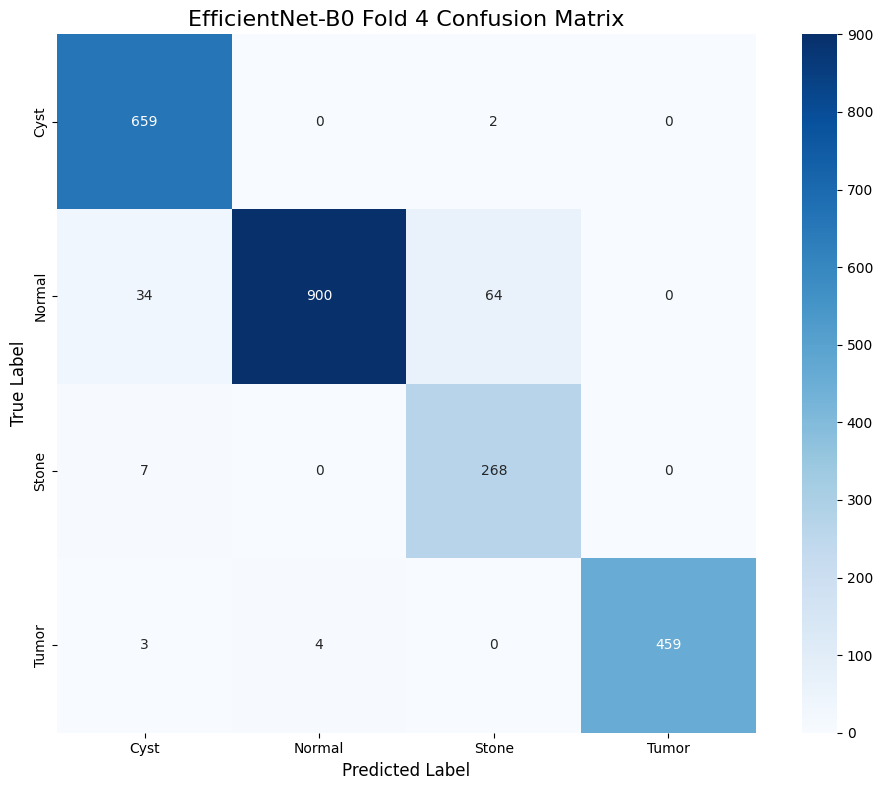

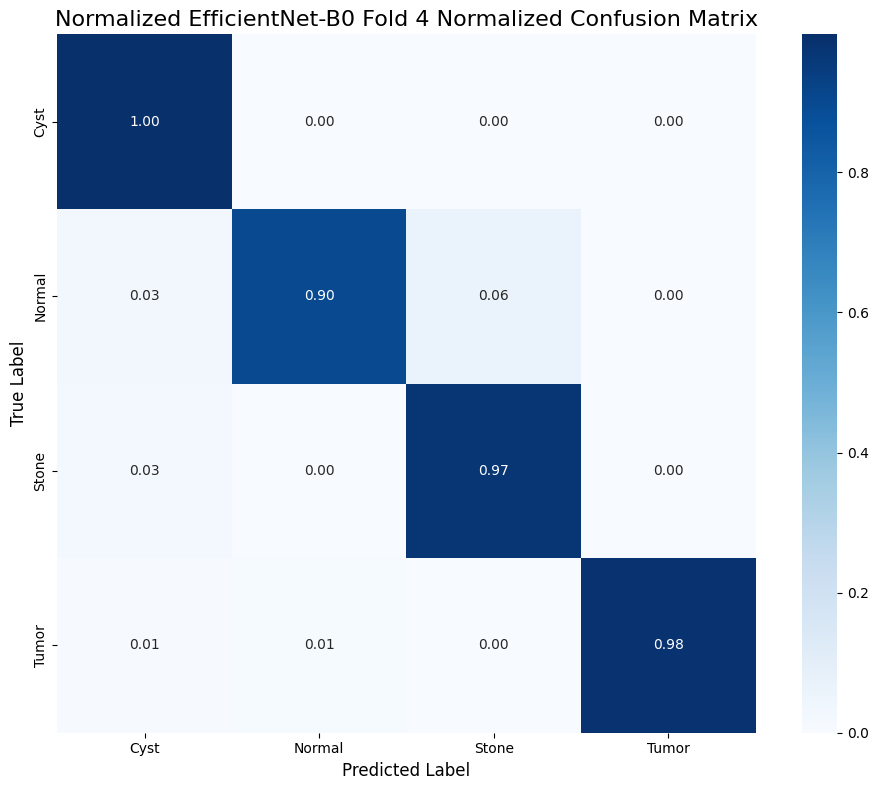


=== Training EfficientNet-B0 on Fold 5/5 ===

Training on 1898 images


Epoch 1:   0%|          | 0/238 [00:00<?, ?it/s]

Epoch 1/10:
  Train Loss: 0.7620, Train Acc: 71.97%


Epoch 2:   0%|          | 0/238 [00:00<?, ?it/s]

Epoch 2/10:
  Train Loss: 0.3612, Train Acc: 87.88%


Epoch 3:   0%|          | 0/238 [00:00<?, ?it/s]

Epoch 3/10:
  Train Loss: 0.2595, Train Acc: 91.31%


Epoch 4:   0%|          | 0/238 [00:00<?, ?it/s]

Epoch 4/10:
  Train Loss: 0.1434, Train Acc: 95.89%


Epoch 5:   0%|          | 0/238 [00:00<?, ?it/s]

Epoch 5/10:
  Train Loss: 0.1532, Train Acc: 95.52%


Epoch 6:   0%|          | 0/238 [00:00<?, ?it/s]

Epoch 6/10:
  Train Loss: 0.0862, Train Acc: 97.37%


Epoch 7:   0%|          | 0/238 [00:00<?, ?it/s]

Epoch 7/10:
  Train Loss: 0.1081, Train Acc: 96.79%


Epoch 8:   0%|          | 0/238 [00:00<?, ?it/s]

Epoch 8/10:
  Train Loss: 0.1008, Train Acc: 96.84%


Epoch 9:   0%|          | 0/238 [00:00<?, ?it/s]

Epoch 9/10:
  Train Loss: 0.0539, Train Acc: 97.95%


Epoch 10:   0%|          | 0/238 [00:00<?, ?it/s]

Epoch 10/10:
  Train Loss: 0.0231, Train Acc: 99.21%
Saved final model to efficientnet_b0_fold5.pth

Fold 5 Results:
  Final Train Acc: 99.21%
  Test Loss: 0.0157, Test Acc: 99.54%

Generating confusion matrix for Fold 5...
Confusion Matrix for Fold 5:
[[658   0   3   0]
 [  0 998   0   0]
 [  4   0 271   0]
 [  0   3   1 462]]

Classification Report for Fold 5:
              precision    recall  f1-score   support

        Cyst       0.99      1.00      0.99       661
      Normal       1.00      1.00      1.00       998
       Stone       0.99      0.99      0.99       275
       Tumor       1.00      0.99      1.00       466

    accuracy                           1.00      2400
   macro avg       0.99      0.99      0.99      2400
weighted avg       1.00      1.00      1.00      2400



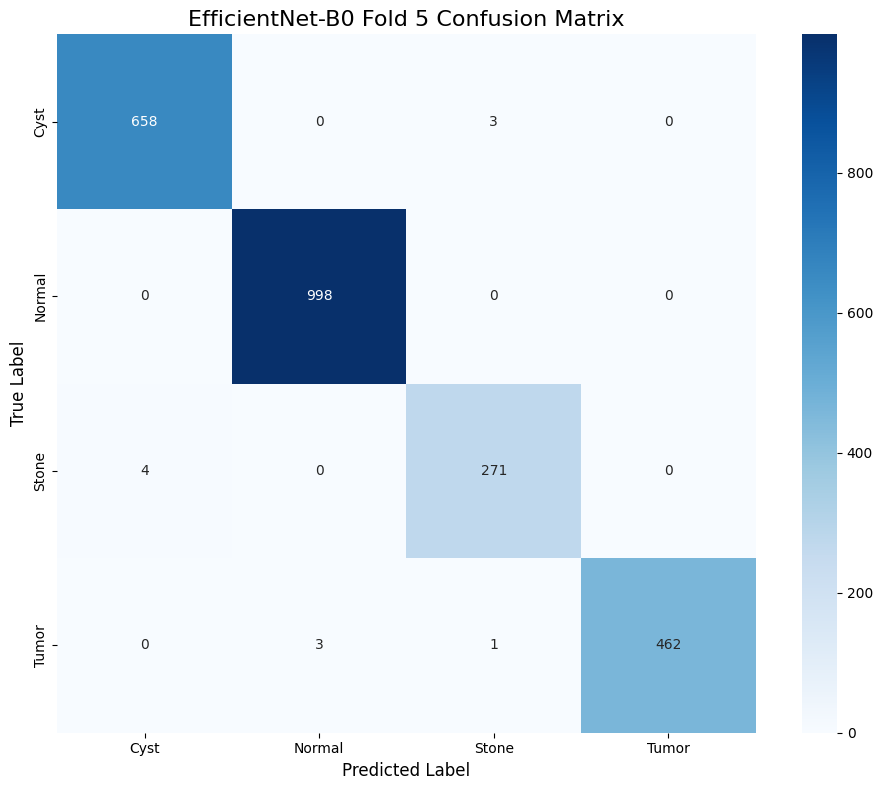

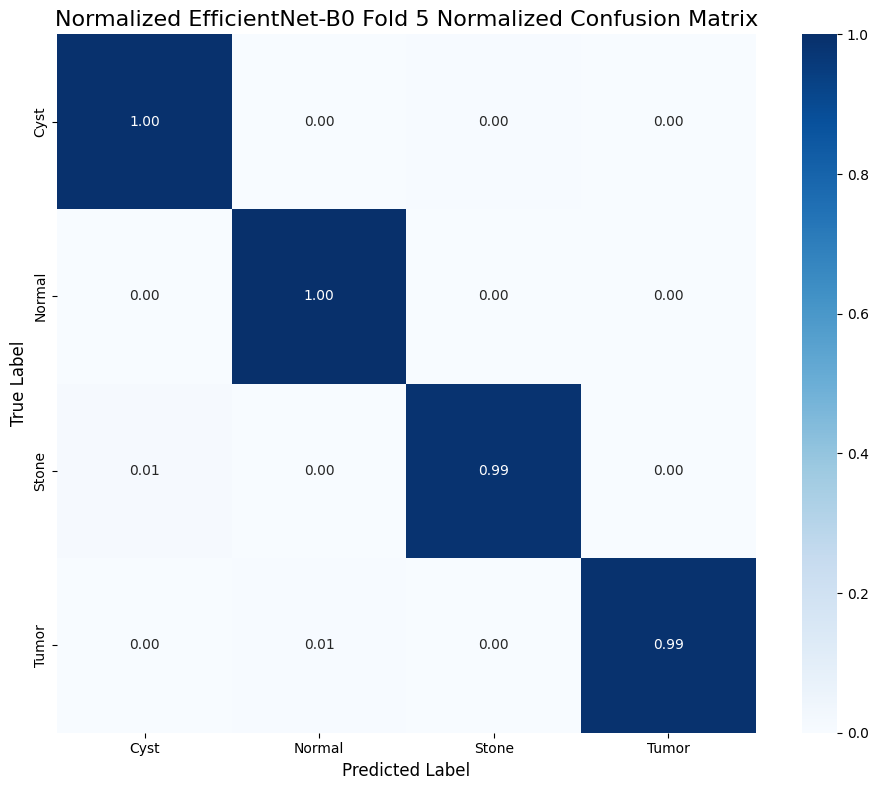


=== Overall EfficientNet-B0 Results ===
Average Train Accuracy: 98.09%
Average Test Accuracy: 97.66%


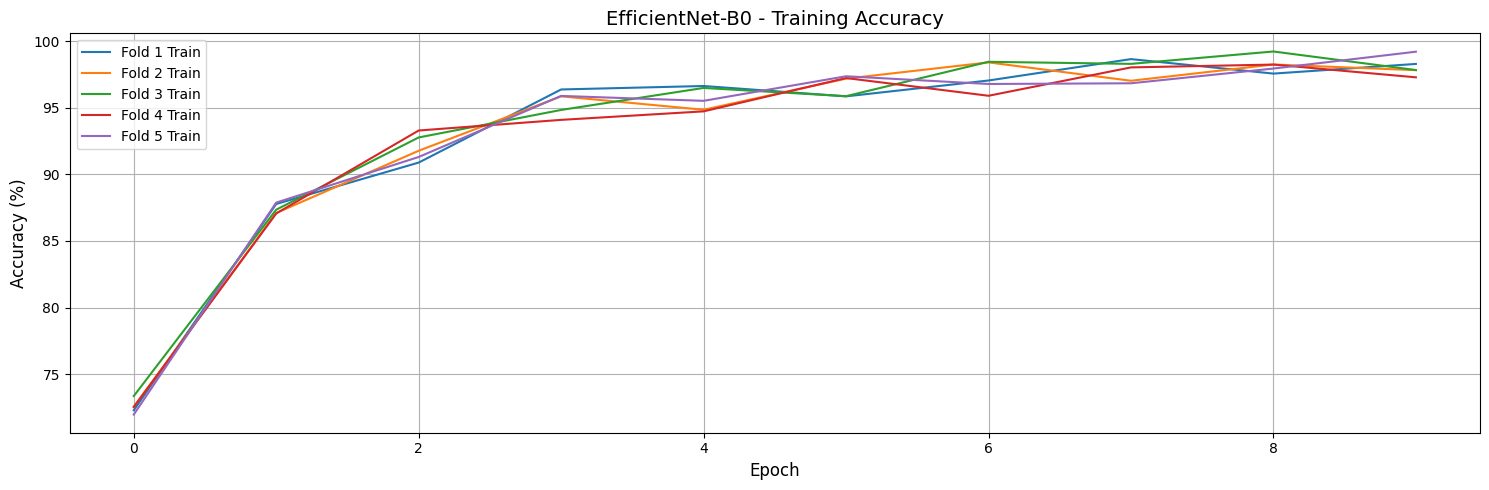

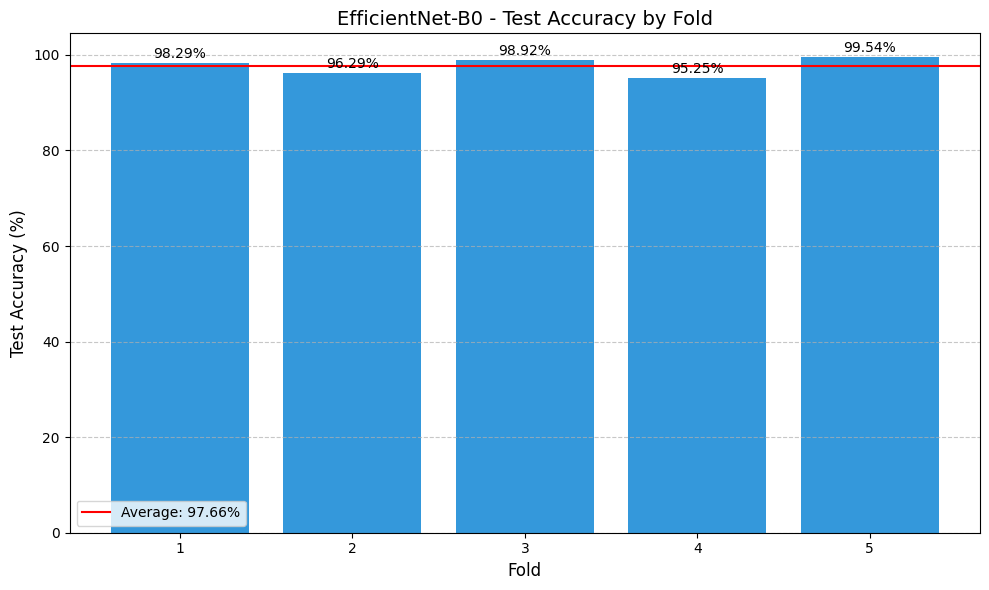

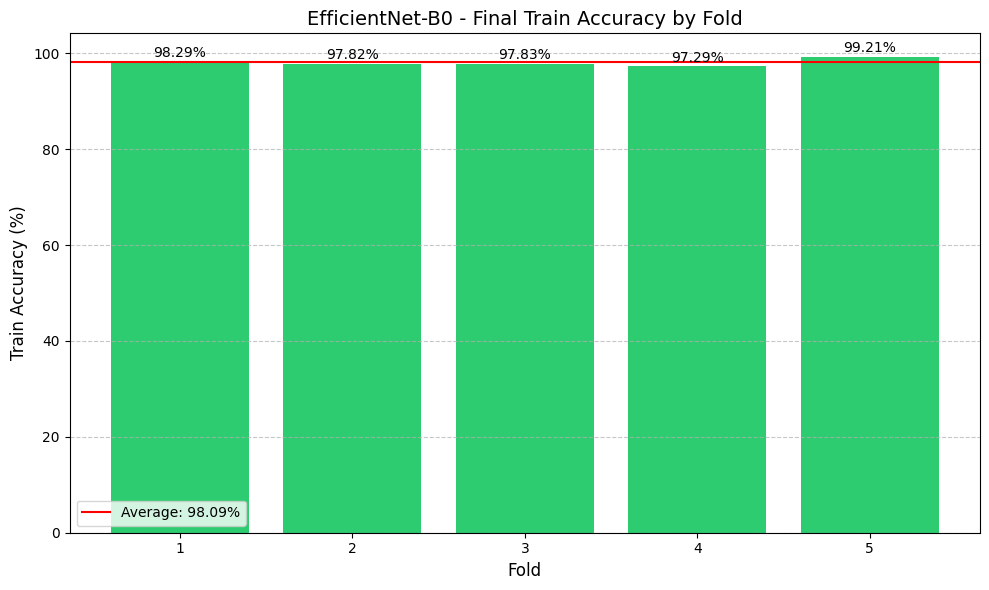

In [13]:
# Run the training
efficientnet_b0_results = train_efficientnet_b0_on_folds(num_epochs=10, batch_size=8)